In [1]:
# Pacotes

# Manipulação de dados em DataFrames
import pandas as pd

# Operações numéricas e matrizes
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt

# Criação de objetos de linha e pontos
from shapely.geometry import LineString
from shapely.geometry import Point

# Manipulação de dados espaciais (GeoDataFrames)
import geopandas as gpd

# Conversão entre WKT (texto) e objetos geométricos
from shapely import wkt

# Transformação de sistemas de coordenadas
from pyproj import Transformer

# Obtenção de dados geográficos da OpenStreetMap
import osmnx as ox

In [2]:
# Bancos de dados
oss = r'C:\Users\amand\Amanda\GitHub\virtual_audit_ai\oss_bhviva_magalhaes_29.08.2025.dta'
virtual = r'C:\Users\amand\Amanda\GitHub\virtual_audit_ai\Auditoria Virtual Amostra Total - 27 cidades.dta'

# Leitura dos arquivos .dta como DataFrames
oss = pd.read_stata(oss)
virtual = pd.read_stata(virtual)

# Verificar número de linhas e colunas de cada base
print(oss.shape)
print(virtual.shape)

C:\Users\amand\AppData\Local\Temp\ipykernel_24436\2035587022.py:6: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  oss = pd.read_stata(oss)


(373, 690)
(2639, 221)


In [3]:
# Manter apenas as variáveis de interesse

oss = oss[['setor', 'vila_entorno', 'data_obs_1', 'X_inicio', 'Y_inicio', 'X_final', 'Y_final']]

virtual = virtual[['identificador', 'cidade', 'data_imagens', 'wkt', 'coordenadas_inicio', 'coordenadas_termino', 'coordenadas_inicio_2', 'coordenadas_termino_2']]

print(oss.shape)
print(virtual.shape)

(373, 7)
(2639, 8)


In [4]:
# Coordenadas OSS

# Criar colunas de coordenadas como tupla
oss['X_Y_inicio'] = list(zip(oss['X_inicio'], oss['Y_inicio']))
oss['X_Y_termino'] = list(zip(oss['X_final'], oss['Y_final']))

# Definir transformador UTM para WGS 84 (assumindo UTM zona 23S - EPSG:31983)
transformer = Transformer.from_crs('EPSG:31983', 'EPSG:4326', always_xy=True)

# Função de conversão
def converter_utm_para_latlon(coordenada):
    if coordenada is None or coordenada == (None, None):
        return (None, None)
    x, y = coordenada
    lon, lat = transformer.transform(x, y)
    return (lat, lon)

# Aplicar conversão
oss['coordenadas_inicio'] = oss['X_Y_inicio'].apply(converter_utm_para_latlon)
oss['coordenadas_termino'] = oss['X_Y_termino'].apply(converter_utm_para_latlon)

# Transformar em string no formato 'lat, lon'
oss['coordenadas_inicio'] = oss['coordenadas_inicio'].apply(
    lambda coord: f'{coord[0]:.6f}, {coord[1]:.6f}' if coord != (None, None) else None)
oss['coordenadas_termino'] = oss['coordenadas_termino'].apply(
    lambda coord: f'{coord[0]:.6f}, {coord[1]:.6f}' if coord != (None, None) else None)

# Excluir coordenadas ausentes (n=3)
oss = oss[~((oss['coordenadas_inicio'] == 'nan, nan') & (oss['coordenadas_termino'] == 'nan, nan'))]
oss.shape

(370, 11)

In [5]:
# Organizar variáveis OSS

oss = oss.rename(columns={'setor': 'id'})
oss['id'] = oss['id'].str.replace('-', '', regex=False)

oss = oss.rename(columns={'vila_entorno': 'area'})

oss = oss.rename(columns={'data_obs_1': 'data'})
oss['data'] = pd.to_datetime(oss['data'], dayfirst=True, errors='coerce')

oss.insert(oss.columns.get_loc('coordenadas_inicio'), 'field', 'oss')

oss = oss.drop(columns=[col for col in ['X_inicio', 'Y_inicio', 'X_final', 'Y_final', 'X_Y_inicio', 'X_Y_termino'] if col in oss.columns])

oss.shape

(370, 6)

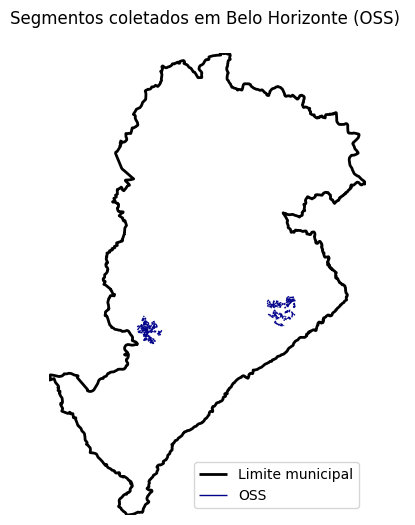

In [6]:
# Plot OSS

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(', ')
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

oss['geometry'] = oss.apply(string_to_linestring, axis=1)

gdf_oss = gpd.GeoDataFrame(oss, geometry='geometry', crs='EPSG:4326')

gdf_bh = ox.geocode_to_gdf('Belo Horizonte, Brazil')

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label='Limite municipal')

gdf_oss.plot(ax=ax, color='darkblue', linewidth=1, alpha=1, label='OSS')

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title('Segmentos coletados em Belo Horizonte (OSS) \n', fontsize=12)
ax.axis('off')

ax.legend(loc='lower right')

plt.show()

In [7]:
# Organizar variáveis auditoria virtual

virtual = virtual.rename(columns={'identificador': 'id'})
virtual = virtual.rename(columns={'data_imagens': 'data'})

virtual['id'] = virtual['id'].astype(str)
virtual['id'] = virtual['id'].astype(str).str.replace(r'\.0$', '', regex=True)


def move_column(df, col_to_move, after_col):
    cols = list(df.columns)
    cols.remove(col_to_move)
    insert_at = cols.index(after_col) + 1
    cols.insert(insert_at, col_to_move)
    return df[cols]
virtual = move_column(virtual, 'wkt', 'coordenadas_termino_2')

virtual.insert(virtual.columns.get_loc('coordenadas_inicio'), 'field', 'virtual')

virtual.shape

(2639, 9)

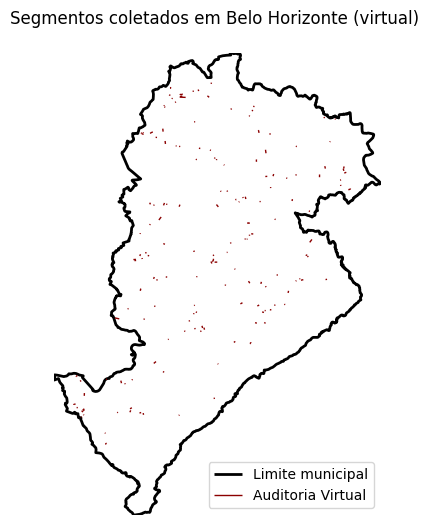

In [8]:
# Plot auditoria virtual

def string_to_point(coord_str):
    if coord_str is None or pd.isna(coord_str):
        return None
    lat_str, lon_str = coord_str.split(', ')
    return float(lon_str), float(lat_str)

def string_to_linestring(row):
    start = string_to_point(row['coordenadas_inicio'])
    end = string_to_point(row['coordenadas_termino'])
    if start is None or end is None:
        return None
    return LineString([start, end])

virtual['geometry'] = virtual['wkt'].apply(wkt.loads)

gdf_virtual = gpd.GeoDataFrame(virtual, geometry='geometry', crs='EPSG:4326')

gdf_bh = ox.geocode_to_gdf('Belo Horizonte, Brazil')

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label='Limite municipal')

gdf_virtual.plot(ax=ax, color='darkred', linewidth=1, alpha=1, label='Auditoria Virtual')

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title('Segmentos coletados em Belo Horizonte (virtual) \n', fontsize=12)
ax.axis('off')

ax.legend(loc='lower right')

plt.show()

In [9]:
# Append oss e auditoria virtual

df = pd.concat([oss, virtual], ignore_index=True)

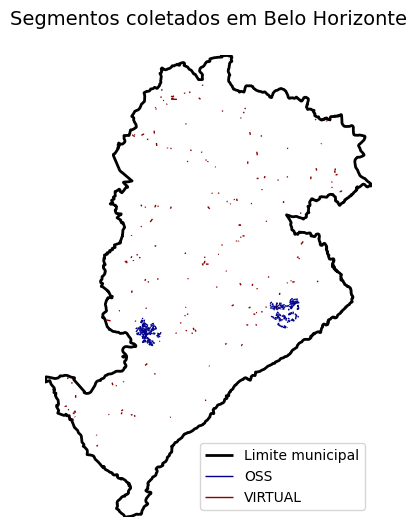

In [10]:
# Plot segmentos

if df['geometry'].dtype == object:
    try:
        df['geometry'] = df['geometry'].apply(wkt.loads)
    except Exception:
        pass

df = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

gdf_bh = ox.geocode_to_gdf('Belo Horizonte, Brazil')

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label='Limite municipal')

colors = {'oss': 'darkblue', 'virtual': 'darkred'}

for tipo, cor in colors.items():
    subset = df[df['field'] == tipo]
    if not subset.empty:
        subset.plot(ax=ax, color=cor, linewidth=1, alpha=1, label=tipo.upper())

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title('Segmentos coletados em Belo Horizonte\n', fontsize=14)
ax.axis('off')
ax.legend(loc='lower right')

plt.show()

In [11]:
# Coordenadas

# Separar coordenadas em latitude e longitude
df[['lat_inicio', 'lon_inicio']] = df['coordenadas_inicio'].str.split(', ', expand=True).astype(float)
df[['lat_termino', 'lon_termino']] = df['coordenadas_termino'].str.split(', ', expand=True).astype(float)

# Calcular ponto médio
df['lat_medio'] = (df['lat_inicio'] + df['lat_termino']) / 2
df['lon_medio'] = (df['lon_inicio'] + df['lon_termino']) / 2

# Combinar lat/lon em formato string
df['coordenadas_medio'] = df['lat_medio'].astype(str) + ', ' + df['lon_medio'].astype(str)

# Função para converter string em Point (Shapely)
def str_para_point(coord):
    lat, lon = map(float, coord.split(', '))
    return Point(lon, lat)

# Criar geometria do ponto médio
df['geometry_point'] = df['coordenadas_medio'].apply(str_para_point)
gdf_pontos = gpd.GeoDataFrame(df.copy(), geometry='geometry_point', crs='EPSG:4326')

# Excluir variáveis
df = df.drop(columns=[col for col in ['lat1', 'lon1', 'lat2', 'lon2'] if col in df.columns])

# Ajustar cidade da OSS
df.loc[df['field'] == 'oss', 'cidade'] = 'Belo Horizonte'

# Reorganizar colunas
df = move_column(df, 'cidade', 'id')
df = move_column(df, 'coordenadas_medio', 'coordenadas_inicio')
df = move_column(df, 'coordenadas_inicio_2', 'coordenadas_termino')
df = move_column(df, 'coordenadas_termino_2', 'coordenadas_inicio_2')
df = move_column(df, 'lat_medio', 'lon_inicio')
df = move_column(df, 'lon_medio', 'lat_medio')
df = move_column(df, 'geometry', 'lon_termino')
df = move_column(df, 'wkt', 'geometry_point')

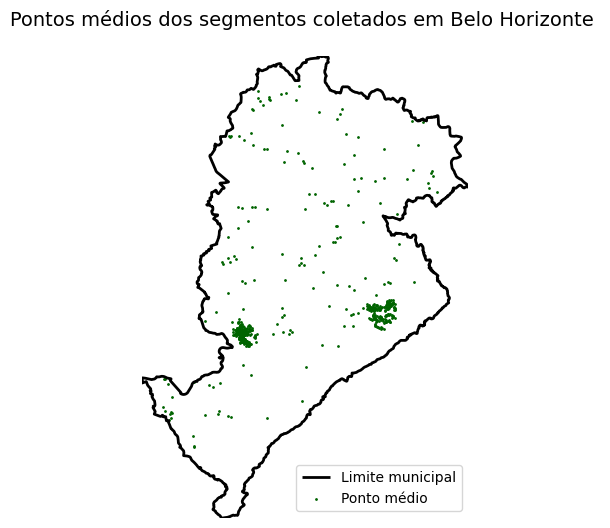

In [12]:
# Plot ponto médio

df = gpd.GeoDataFrame(df, geometry='geometry_point', crs='EPSG:4326')

gdf_bh = ox.geocode_to_gdf('Belo Horizonte, Brazil')

fig, ax = plt.subplots(figsize=(5, 6))

gdf_bh.boundary.plot(ax=ax, edgecolor='black', linewidth=2, label='Limite municipal')

gdf_pontos.plot(ax=ax, color='darkgreen', markersize=1, label='Ponto médio')

xmin, ymin, xmax, ymax = gdf_bh.total_bounds
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_title('Pontos médios dos segmentos coletados em Belo Horizonte \n', fontsize=14)
ax.axis('off')
ax.legend(loc='lower right')

plt.show()

In [13]:
# Gerar pontos ao longo de cada linha a cada 25 m aproximados,
# mantendo sempre o ponto inicial e o final,
# e evitando que o último segmento fique muito pequeno (menos que metade da distância alvo)

# Criar geometria da linha a partir das coordenadas
def str_to_point(coord):
    lat, lon = map(float, coord.split(', '))
    return Point(lon, lat)

def str_to_linestring(row):
    start = str_to_point(row['coordenadas_inicio'])
    end = str_to_point(row['coordenadas_termino'])
    return LineString([start, end])

df['geometry_line'] = df.apply(str_to_linestring, axis=1)
gdf_lines = gpd.GeoDataFrame(df.copy(), geometry='geometry_line', crs='EPSG:4326')

# Projetar para CRS métrico
gdf_lines_m = gdf_lines.to_crs(epsg=3857)

# Função para gerar pontos a cada 25 m, mantendo início e fim,
# evitando trechos muito pequenos no final
def sample_line_25m_keep_min(line, distance_m=25, min_last_segment_ratio=0.5):
    total_length = line.length
    if total_length == 0:
        return [line.interpolate(0)]
    
    distances = [0]  # ponto inicial
    current = distance_m
    
    while current < total_length:
        distances.append(current)
        current += distance_m
    
    # Verifica se o último segmento é muito pequeno
    last_segment = total_length - distances[-1]
    if last_segment < distance_m * min_last_segment_ratio and len(distances) > 1:
        distances = distances[:-1]  # descarta penúltimo ponto
    
    distances.append(total_length)  # sempre inclui ponto final
    return [line.interpolate(d) for d in distances]

# Gerar pontos para todas as linhas
all_points = []

for idx, row in gdf_lines_m.iterrows():
    points = sample_line_25m_keep_min(row['geometry_line'], distance_m=25)
    for i, pt in enumerate(points):
        all_points.append({
            'id': row['id'],
            'cidade': row['cidade'],
            'field': row['field'],
            'points': i + 1,
            'geometry': pt
        })

# Criar GeoDataFrame com os pontos
gdf_sampled = gpd.GeoDataFrame(all_points, geometry='geometry', crs=gdf_lines_m.crs)

# Voltar para WGS84
gdf_sampled = gdf_sampled.to_crs(epsg=4326)

# Criar colunas separadas de latitude e longitude
gdf_sampled['lat'] = gdf_sampled.geometry.y.astype(float)
gdf_sampled['lon'] = gdf_sampled.geometry.x.astype(float)

# Reorganizar colunas
cols = ['id', 'cidade', 'field', 'points', 'lat', 'lon']
gdf_sampled = gdf_sampled[cols]

# Ajustar cidade para 'Belo Horizonte' quando field == 'oss'
gdf_sampled.loc[gdf_sampled['field'] == 'oss', 'cidade'] = 'Belo Horizonte'

# Renomear coluna para 'city'
gdf_sampled = gdf_sampled.rename(columns={'cidade': 'city'})

pd.set_option('display.float_format', '{:.10f}'.format)
gdf_sampled.tail(8)

,id,city,field,points,lat,lon
16931,3550308107707,São Paulo,virtual,1,-23.4932628000,-46.5763398000
16932,3550308107707,São Paulo,virtual,2,-23.4931146066,-46.5761838352
16933,3550308107707,São Paulo,virtual,3,-23.4929664131,-46.5760278703
16934,3550308107707,São Paulo,virtual,4,-23.4928182194,-46.5758719055
16935,3550308107707,São Paulo,virtual,5,-23.4926700255,-46.5757159407
16936,3550308107707,São Paulo,virtual,6,-23.4925218314,-46.5755599758
16937,3550308107707,São Paulo,virtual,7,-23.4923736372,-46.5754040110
16938,3550308107707,São Paulo,virtual,8,-23.4921777000,-46.5751978000


In [14]:
# Visualizar distância entre os pontos

# Garantir que gdf_sampled seja GeoDataFrame com geometry
if not isinstance(gdf_sampled, gpd.GeoDataFrame):
    gdf_sampled['geometry'] = gpd.points_from_xy(gdf_sampled['lon'], gdf_sampled['lat'])
    gdf_sampled = gpd.GeoDataFrame(gdf_sampled, geometry='geometry', crs='EPSG:4326')

# Reprojetar para métrico
gdf_sampled = gdf_sampled.to_crs(epsg=3857)

# Ordenar os dados por id e points
gdf_sampled = gdf_sampled.sort_values(['id', 'points']).copy()

# Calcular a distância para o próximo ponto dentro de cada id
gdf_sampled['dist'] = gdf_sampled.groupby('id')['geometry'].shift(-1).distance(gdf_sampled['geometry'])

# Substituir NaN por "."
gdf_sampled['dist'] = gdf_sampled['dist'].fillna(".")

# Voltar para lat/lon
gdf_sampled = gdf_sampled.to_crs(epsg=4326)

# Visualizar
gdf_sampled[['id', 'points', 'lat', 'lon', 'dist']]

,id,points,lat,lon,dist
0,0562002001,1,-19.9309720000,-43.9197900000,24.9999999998
1,0562002001,2,-19.9307816420,-43.9196928657,25.0000000006
2,0562002001,3,-19.9305912837,-43.9195957315,24.9999999990
3,0562002001,4,-19.9304009253,-43.9194985972,25.0000000002
4,0562002001,5,-19.9302105666,-43.9194014630,21.4813367793
...,...,...,...,...,...
9741,530010898466,1,-15.8344067000,-47.9206131000,25.0000000007
9742,530010898466,2,-15.8342739086,-47.9204359457,25.0000000000
9743,530010898466,3,-15.8341411171,-47.9202587913,24.9999999981
9744,530010898466,4,-15.8340083256,-47.9200816370,26.0418431907


In [15]:
# Selecionar todas as colunas exceto 'geometry'
cols_to_export = [c for c in gdf_sampled.columns if c != 'geometry']

# Salvar em Excel
gdf_sampled[cols_to_export].to_excel('coordinates.xlsx', index=False)